In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
from scipy.optimize import curve_fit

[reference 1](https://matplotlib.org/users/event_handling.html)<br>
[reference 2](https://blog.csdn.net/yjl9122/article/details/70762476)<br>
[reference 3](https://stackoverflow.com/questions/48446351/distinguish-button-press-event-from-drag-and-zoom-clicks-in-matplotlib)<br>

Might be used:
[reference 1](https://blog.csdn.net/yjl9122/article/details/70762476)

In [58]:
class interactive_figure():
    def __init__(self, name, figure, ax, selected_points, rect, L2_min, data):
        self.name = name
        self.figure = figure
        self.ax = ax
        self.selected_points = selected_points
        self.rect = rect
        self.selected_points_xs = list(selected_points.get_xdata())
        self.selected_points_ys = list(selected_points.get_ydata())
        self.x_select = 0.
        self.y_select = 0.
        self.data = data
        
#         self.message = [] # for debug
        self.pressed = False
        self.moved = False
        self.released = False
        self.add_mode = False
        self.subtract_mode = False
        ############### for fitting
        self.do_fit = False
        self.has_fit = False
        self.parameters = [] 
        self.fitting_result = []
        ###############
        self.recorder = []
        self.criteria = L2_min
        self.import_function()
        
    def activate(self, curves_dict):
        for i in curves_dict.keys():
            if i == self.name:
                self.connect()
                self.selected_points.figure.canvas.draw()
            else:
                curves_dict[i].rect.set_linewidth(0.0)
                try:
                    curves_dict[i].disconnect() # be sure to disconnect the other curves so their points won't be selected when you deal with a certain curve!
                except:
                    pass
                
    def L2_distance(self, xy, x0, y0):
        return ((xy[:,0]-x0)**2+(xy[:,1]-y0)**2)**0.5
    
    def import_function(self, plotting_points = 200):
        flag = input("Will do fitting for %s? (y for yes)"%self.name)
        if flag == 'y' or flag=='yes':
            self.do_fit = True
            self.plotting_points = plotting_points
            function_name = input("Please import the function:")
            self.function = function_library[function_name]
            number_parameters = int(input("Pleae enter the number of parameters:"))
            for i in range(number_parameters):
                self.parameters.append(eval(input("Pleas enter the value for #%d parameter:"%(i+1))))
        else:
            print("Would not do fitting for %s."%self.name)
        
    def connect(self):
        self.cidpress = self.figure.canvas.mpl_connect(
            'button_press_event', self.on_press)
        self.cidrelease = self.figure.canvas.mpl_connect(
            'button_release_event', self.on_release)
        self.cidmotion = self.figure.canvas.mpl_connect(
            'motion_notify_event', self.on_motion)
        self.cidpresskey = self.figure.canvas.mpl_connect(
            'key_press_event', self.press_key)
        self.cidreleasekey = self.figure.canvas.mpl_connect(
            'key_release_event', self.release_key)
        
    def on_press(self, event):
        if event.inaxes != self.selected_points.axes:
            return
        # single point is selected
        self.x_select, self.y_select = event.xdata, event.ydata
        cache = list(self.L2_distance(self.data, self.x_select, self.y_select))
        index = list(filter(lambda x: cache[x]<self.criteria, range(0,len(self.data))))
        number = len(index)
        
        if number>=1:
            if number ==1:
                index = index[0]
            elif number>1:
                index = index[np.argmin([cache[x] for x in index])]
            self.x_select, self.y_select = self.data[index][0], self.data[index][1]
            if self.x_select in self.selected_points_xs: # since y is a function of x, only need to distinguish x
                index = self.selected_points_xs.index(self.x_select)
                del self.selected_points_xs[index]
                del self.selected_points_ys[index]
                del self.recorder[index]
                self.selected_points.set_data(self.selected_points_xs, self.selected_points_ys)
                self.selected_points.figure.canvas.draw()
                return
            self.selected_points_xs.append(self.x_select)
            self.selected_points_ys.append(self.y_select)
            self.selected_points.set_data(self.selected_points_xs, self.selected_points_ys)
            self.selected_points.figure.canvas.draw()
            self.recorder.append([self.x_select,self.y_select])
        #######
        # Drag to form window
        else:
            self.pressed = True
            self.rect.set_x(self.x_select)
            self.rect.set_y(self.y_select)
            
#             self.rect.set_animated(True)
            canvas = self.rect.figure.canvas
            canvas.draw()
            self.background = canvas.copy_from_bbox(self.rect.axes.bbox)

    def on_motion(self, event):
        if not self.pressed or event.inaxes != self.selected_points.axes:
            return
        self.moved = True
        if self.add_mode or self.subtract_mode:
            x_now, y_now = event.xdata, event.ydata
            self.rect.set_width(x_now-self.x_select)
            self.rect.set_height(y_now-self.y_select)
            self.rect.set_linewidth(1.5)
#             self.rect.figure.canvas.draw()

            canvas = self.rect.figure.canvas
            axes = self.rect.axes
            canvas.restore_region(self.background)  # restore the background region
            axes.draw_artist(self.rect)  # redraw just the current rectangle
            canvas.blit(axes.bbox)  # blit just the redrawn area
        
    def on_release(self, event):
        if not self.moved or event.inaxes != self.selected_points.axes:
            return
        if self.add_mode or self.subtract_mode:
            
#             self.rect.set_animated(False)
            self.background = None
            
            self.rect.set_linewidth(0.0)
            self.rect.figure.canvas.draw()
            
        self.pressed = False
        self.moved = False
        x_now, y_now = event.xdata, event.ydata
        x_sorted = sorted([self.x_select,x_now])
        y_sorted = sorted([self.y_select,y_now])
        for i in self.data[[(self.data[:,0]<x_sorted[1]) & (self.data[:,0]>x_sorted[0]) & \
                         (self.data[:,1]<y_sorted[1]) & (self.data[:,1]>y_sorted[0])]]:
            if i[0] not in self.selected_points_xs and self.add_mode:  # since y is a function of x, only need to distinguish x
                self.selected_points_xs.append(i[0])
                self.selected_points_ys.append(i[1])
                self.recorder.append([i[0],i[1]])
            elif i[0] in self.selected_points_xs and self.subtract_mode:
                index = self.selected_points_xs.index(i[0])
                del self.selected_points_xs[index]
                del self.selected_points_ys[index]
                del self.recorder[index]
                
        self.selected_points.set_data(self.selected_points_xs, self.selected_points_ys)
        self.selected_points.figure.canvas.draw()
        
    def press_key(self, event):
        if event.key == "alt+s":
#             self.message.append("subtract")
            self.subtract_mode = True
        elif event.key == "alt+a":
#             self.message.append("add")
            self.add_mode = True
        elif event.key == "alt+g" and self.do_fit and len(self.selected_points_xs)>1:
            x = np.array(self.selected_points_xs)
            y = np.array(self.selected_points_ys)
#             self.message.append("Let's fit.")
            self.fitting_result = curve_fit(self.function, x, y, p0 = np.array(self.parameters))
            self.has_fit = True
            if self.has_fit:
                x = np.linspace(min(self.selected_points_xs),max(self.selected_points_xs),self.plotting_points)
                y = self.function(x, self.fitting_result[0])
                self.ax.plot(x, y, lw=1.0, ls='--', c='red')
            
    def release_key(self, event):
        if event.key == "alt+s":
            self.subtract_mode = False
        elif event.key == "alt+a":
            self.add_mode = False

    def disconnect(self):
        self.figure.canvas.mpl_disconnect(self.cidpress)
        self.figure.canvas.mpl_disconnect(self.cidrelease)
        self.figure.canvas.mpl_disconnect(self.cidmotion)
        self.figure.canvas.mpl_disconnect(self.cidpresskey)
        self.figure.canvas.mpl_disconnect(self.cidreleasekey)

### Function Library
Only for this demo. If you want to applied this notebook to other fittings, please build your own library.

In [6]:
def sin(x, a, b=None, c=None):
    if type(a) == list or type(a) == np.ndarray:
        a, b, c = a[0], a[1], a[2]  # for using y = self.function(x, self.fitting_result[0]) command to plot
    return a*np.sin(x+c)+b

def cos(x, a, b=None, c=None):
    if type(a) == list or type(a) == np.ndarray:
        a, b, c = a[0], a[1], a[2]  # for using y = self.function(x, self.fitting_result[0]) command to plot
    return a*np.cos(x+c)+b

function_library = {'sin':sin, 'cos':cos}

### Manual
1. Enter the parameters according to the instruction.
2. Prss "alt+a", then drag the mouse. All points inside the region covered will be selected.
3. Prss "alt+s", then drag the mosse. If there are pre-selected points inside the region covered, they will be dropped out.
4. If click the mouse on a certain point, it will be selected if it was not pre-selected, and will be dropped out if it was selected. If there is difficult for clicking the desired point, you can try adjusting the <b>L2_min</b> paramter, which control how large the effective region near that point. 
5. After enough points are selected, and fitting is enable when initialing the object, "alt+g" can be pressed and automatic fitting will be performed. 

In [64]:
interactive_fig_1.selected_points_xs, interactive_fig_1.selected_points_ys

([1.6, 7.800000000000001], [0.9995736030415051, 0.998543345374605])

<IPython.core.display.Javascript object>


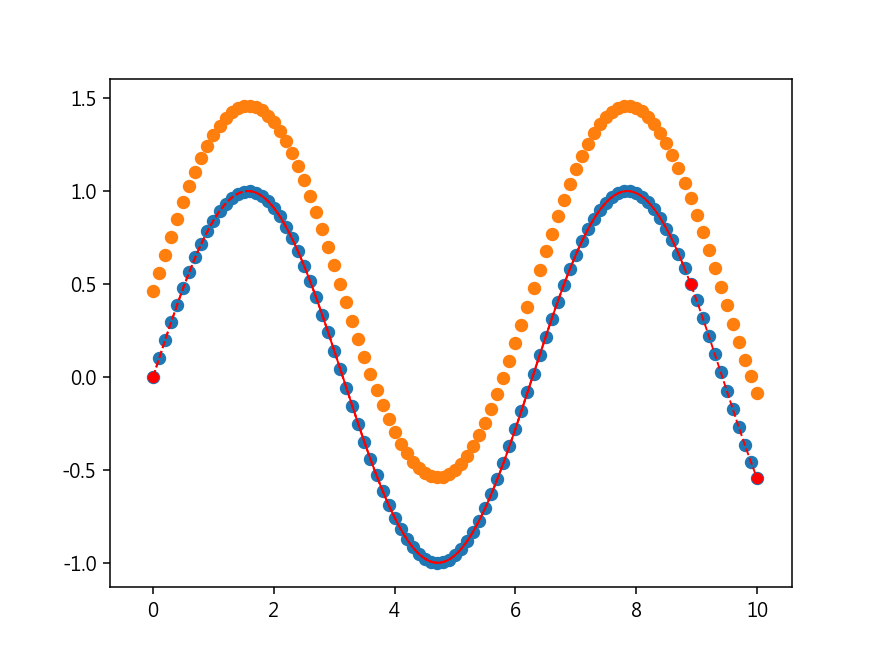

Will do fitting for Curve 1? (y for yes)y
Please import the function:cos
Pleae enter the number of parameters:3
Pleas enter the value for #1 parameter:5
Pleas enter the value for #2 parameter:6
Pleas enter the value for #3 parameter:7
Will do fitting for Curve 2? (y for yes)n
Would not do fitting for Curve 2.


In [60]:
%matplotlib notebook
# %matplotlib ipympl

f,a = plt.subplots()
x = np.linspace(0,10,101)
y_1 = np.sin(x)
y_2 = np.sin(x)+0.46
points_1 = np.vstack((x,y_1)).T
points_2 = np.vstack((x,y_2)).T
a.scatter(x,y_1)
a.scatter(x,y_2)

L2_min = abs((x[0]-x[1]))*0.25

selected_points, = a.plot([], [], lw=0.0, markersize=5.0, marker = "o", c='red')
rect = patches.Rectangle((0.0,0.0),-0.2,-0.2, lw=0., ls= "--", edgecolor='k',facecolor='none')
a.add_patch(rect)

interactive_fig_1 = interactive_figure("Curve 1", f, a, selected_points, rect, L2_min, points_1)
interactive_fig_2 = interactive_figure("Curve 2", f, a, selected_points, rect, L2_min, points_2)
# f.canvas.mpl_connect('button_press_event', onclick)
curves_dict = {interactive_fig_1.name: interactive_fig_1, interactive_fig_2.name: interactive_fig_2}
f.show()

In [61]:
interactive_fig_1.activate(curves_dict)

In [55]:
interactive_fig_2.activate(curves_dict)

In [62]:
interactive_fig_1.activate(curves_dict)

### Check whether fitting is enabled.

In [23]:
interactive_fig_1.do_fit, interactive_fig_2.do_fit

(True, True)

### Check the fitting result.

In [63]:
interactive_fig_1.has_fit, interactive_fig_1.fitting_result

(True,
 (array([9.99999999e-01, 1.34083211e-10, 8.87672712e+04]),
  array([[ 2.09054324e-20, -2.89382961e-21, -6.16660094e-21],
         [-2.89382961e-21,  9.47957916e-20,  1.42052161e-20],
         [-6.16660094e-21,  1.42052161e-20,  2.62264773e-20]])))

In [52]:
interactive_fig_2.has_fit, interactive_fig_2.fitting_result

(True,
 (array([-1.        ,  0.46      ,  7.85398163]),
  array([[ 1.44237336e-28,  1.42570241e-28, -2.29765233e-30],
         [ 1.42570241e-28,  1.40941796e-28, -2.27439247e-30],
         [-2.29765233e-30, -2.27439247e-30,  8.80581629e-31]])))

### Check all the selected points.
The selected points allowed further data processing.

In [65]:
temp = [print("%.2f %.6f"%(i[0],i[1])) for i in interactive_fig_1.recorder]

3.60 -0.442520
3.70 -0.529836
3.80 -0.611858
5.80 -0.464602
5.90 -0.373877
5.60 -0.631267
5.70 -0.550686
6.00 -0.279415
5.20 -0.883455
0.30 0.295520
0.40 0.389418
0.50 0.479426
0.60 0.564642
0.70 0.644218
0.80 0.717356
0.90 0.783327
1.00 0.841471
1.10 0.891207
1.20 0.932039
1.30 0.963558
1.40 0.985450
1.50 0.997495
1.60 0.999574
1.70 0.991665
1.80 0.973848
1.90 0.946300
2.00 0.909297
2.10 0.863209
2.20 0.808496
2.30 0.745705
7.00 0.656987
7.10 0.728969
7.20 0.793668
7.30 0.850437
7.40 0.898708
7.50 0.938000
7.60 0.967920
7.70 0.988168
7.80 0.998543
7.90 0.998941
8.00 0.989358
9.40 0.024775
9.50 -0.075151
9.60 -0.174327
9.70 -0.271761
9.80 -0.366479
9.90 -0.457536
6.60 0.311541
6.70 0.404850
6.80 0.494113


In [66]:
temp = [print("%.2f %.6f"%(i[0],i[1])) for i in interactive_fig_2.recorder]

2.90 0.699249
3.00 0.601120
3.10 0.501581
3.20 0.401626
3.30 0.302254
3.40 0.204459
3.50 0.109217
3.60 0.017480
3.70 -0.069836
3.80 -0.151858
3.90 -0.227766
4.00 -0.296802
4.10 -0.358277
4.20 -0.411576
4.30 -0.456166
4.40 -0.491602
6.30 0.476814
6.40 0.576549
6.50 0.675120
6.60 0.771541
6.70 0.864850
6.80 0.954113
7.00 1.116987
7.10 1.188969
7.20 1.253668
7.30 1.310437
7.40 1.358708
7.50 1.398000
9.20 0.682890
9.30 0.584454
4.50 -0.517530
4.60 -0.533691
4.70 -0.539923
4.80 -0.536165
4.90 -0.522453
5.00 -0.498924
5.10 -0.465815
5.20 -0.423455
5.30 -0.372267
5.40 -0.312764
5.50 -0.245540
5.60 -0.171267
0.60 1.024642
0.70 1.104218
0.80 1.177356
0.90 1.243327
